Train on 5080 samples, validate on 2007 samples
Epoch 1/10
5080/5080 [==============================] - 23s 5ms/step - loss: 0.0438 - acc: 1.9685e-04 - val_loss: 0.0364 - val_acc: 4.9826e-04
Epoch 2/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0105 - val_acc: 4.9826e-04
Epoch 3/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0107 - val_acc: 4.9826e-04
Epoch 4/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 4.9826e-04
Epoch 5/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0107 - val_acc: 4.9826e-04
Epoch 6/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0109 - val_acc: 4.9826e-04
Epoch 7/10
5080/5080 [==============================] - 22s 4ms/step - loss: 0.0047 - acc: 0.0

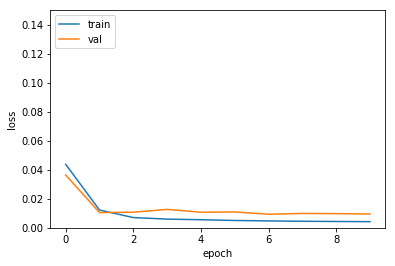

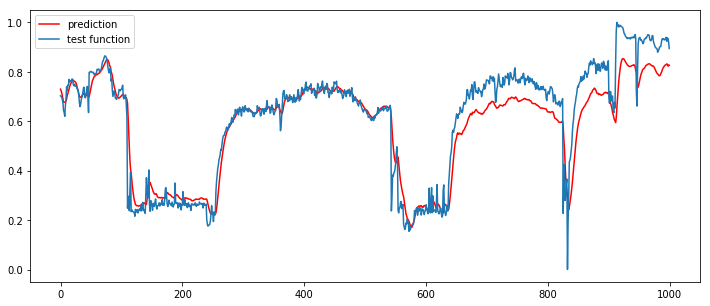

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

np.random.seed(5)
np.set_printoptions(threshold=np.nan, formatter=dict(float=lambda x: "%.3f" % x))
log = open('log.keras_lstm', 'w')


class CustomHistory(keras.callbacks.Callback):
	def init(self):
		self.train_loss=[]
		self.val_loss=[]    

	def on_epoch_end(self, batch, logs={}):
		self.train_loss.append(logs.get('loss'))
		self.val_loss.append(logs.get('val_loss'))


def create_dataset(dataset, look_back, features):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		dataX.append(dataset[i:(i + look_back)])
		dataY.append(dataset[i + look_back, 12])	
	return np.array(dataX), np.array(dataY)
		


# file loader
sydtpath = "./"
naturalEndoTekCode = "onp_dcs_1_60s_sample"
fullpath = sydtpath + os.path.sep + naturalEndoTekCode + '.csv'
pandf = pd.read_csv(fullpath, index_col="time")

# convert nparray
nparr = pandf.values
nparr.astype('float32')
#log.write(nparr)

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)
#nptf = nparr

# split train, test
train_size = int(len(nptf) * 0.7)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size, :], nptf[train_size:len(nptf), :]
#print(len(train), len(test))
	 
# create dataset for learning
look_back = 300
features = 23
trainX, trainY = create_dataset(train, look_back, features)
testX, testY = create_dataset(test, look_back, features)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], features))

#print(trainY)
#print('-------------------')
#trainY = np_utils.to_categorical(trainY)
#one_hot_vec_size = trainY.shape[1]
#print("One hot encoding vector size is ", one_hot_vec_size)
#print(trainY)
#print('-------------------')

#print(trainX)
#print('-------------------')
#print(testX)
#sys.exit()

# simple lstm network learning
model = Sequential()
'''
for i in range(2):
	model.add(LSTM(32, batch_input_shape=(1, look_back, features), stateful=True, return_sequences=True))
	model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, features), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
''' 
model.add(LSTM(128, input_shape=(None, features)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#history = CustomHistory()
#history.init()

'''
num_epochs = 10
for epoch_idx in range(num_epochs):
	print('epochs : ' + str(epoch_idx))
	log.write('epochs : ' + str(epoch_idx) + '\n')
	model.fit(trainX, trainY, epochs=1, batch_size=2, verbose=2, shuffle=False, callbacks=[history], validation_data=(testX, testY))
	model.reset_states()
'''
hist = model.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY))
model.reset_states()

%matplotlib inline
#import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

'''
train_scores = model.evaluate(trainX, trainY, batch_size=32)
print("(train)%s: %.3f%%" %(model.metrics_names[0], train_scores[0]*100))
log.write("(train)%s: %.3f%%\n" %(model.metrics_names[0], train_scores[0]*100))
print("(train)%s: %.3f%%" %(model.metrics_names[1], train_scores[1]*100))
log.write("(train)%s: %.3f%%\n" %(model.metrics_names[1], train_scores[1]*100))
model.reset_states()
test_scores = model.evaluate(testX, testY, batch_size=32)
print("(test)%s: %.3f%%" %(model.metrics_names[0], test_scores[0]*100))
log.write("(test)%s: %.3f%%\n" %(model.metrics_names[0], test_scores[0]*100))
print("(test)%s: %.3f%%" %(model.metrics_names[1], test_scores[1]*100))
log.write("(test)%s: %.3f%%\n" %(model.metrics_names[1], test_scores[1]*100))
model.reset_states()
'''
look_ahead = 1000

#xhat = testX[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([testX[i]]), batch_size=128)
    predictions[i] = prediction
    #xhat = np.vstack([xhat[1:],prediction])

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),testY[:look_ahead],label="test function")
plt.legend()
plt.show()

